In [ ]:
!pip install -q datasets transformers
!pip install -qU accelerate

In [2]:
from datasets import load_dataset
imagenet = load_dataset(
    'frgfm/imagenette',
    '320px',
    split='validation',
    revision="4d512db"
)
imagenet

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

In [2]:
set(imagenet['label'])

In [9]:
labels = imagenet.features['label'].names
labels

['tench',
 'English springer',
 'cassette player',
 'chain saw',
 'church',
 'French horn',
 'garbage truck',
 'gas pump',
 'golf ball',
 'parachute']

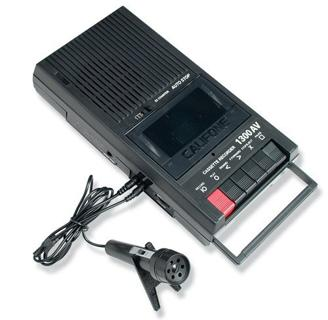

In [11]:
imagenet[0]['image']

In [12]:
clip_labels = [f"a photo of a {label}" for label in labels]
clip_labels

['a photo of a tench',
 'a photo of a English springer',
 'a photo of a cassette player',
 'a photo of a chain saw',
 'a photo of a church',
 'a photo of a French horn',
 'a photo of a garbage truck',
 'a photo of a gas pump',
 'a photo of a golf ball',
 'a photo of a parachute']

In [13]:
from transformers import CLIPProcessor, CLIPModel
model_id =  "openai/clip-vit-base-patch32"
tokenizer = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [15]:
label_tokens = tokenizer(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
)
print(label_tokens['input_ids'].shape)
label_tokens['input_ids'][0][:10]

torch.Size([10, 8])


tensor([49406,   320,  1125,   539,   320,  1149,   634, 49407])

In [16]:
label_emb = model.get_text_features(**label_tokens)
label_emb = label_emb.detach().cpu().numpy()
label_emb.shape

(10, 512)

In [17]:
label_emb.min(), label_emb.max()

(-1.9079247, 6.171627)

In [18]:
import numpy as np
label_emb = label_emb / np.linalg.norm(label_emb, axis=0)
label_emb.min(), label_emb.max()

(-0.8760549, 0.8961744)

In [19]:
image = tokenizer(
    text=None,
    images=imagenet[0]['image'],
    return_tensors='pt'
)['pixel_values']
image.shape

torch.Size([1, 3, 224, 224])

In [20]:
img_emb = model.get_image_features(image)
img_emb.shape

torch.Size([1, 512])

In [21]:
img_emb = img_emb.detach().cpu()

In [23]:
scores = np.dot(img_emb, label_emb.T)
scores.shape

(1, 10)

In [24]:
pred = np.argmax(scores)
pred

2

In [25]:
labels[pred]

'cassette player'

In [29]:
from tqdm import tqdm
preds = []
batch_size = 32
for i in tqdm(range(0, len(imagenet), batch_size)):
  i_end = min(i+batch_size, len(imagenet))
  images = tokenizer(
      text=None,
      images=imagenet[i:i_end]['image'],
      return_tensors='pt'
  )['pixel_values']
  img_emb = model.get_image_features(images)
  img_emb  = img_emb.detach().cpu().numpy()
  scores = np.dot(img_emb, label_emb.T)
  preds.extend(np.argmax(scores, axis=1))

100%|██████████| 123/123 [12:16<00:00,  5.99s/it]


In [30]:
true_preds = []
for i, label in enumerate(imagenet['label']):
  if label == preds[i]:
    true_preds.append(1)
  else:
    true_preds.append(0)
sum(true_preds)/len(true_preds)

0.9870063694267516